In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['F24'] > 0] # 8,486

n_lum_bins = 30 # number of luminosity bins
mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
all_mag_bins = [30, 25, 25, 20, 15, 10] # number of absolute magnitude bins in each redshift bin
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

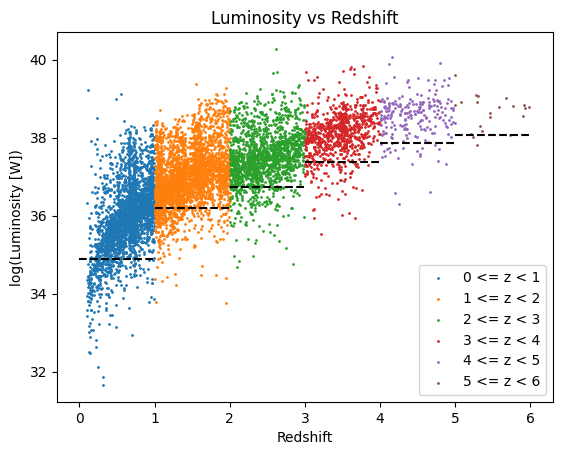

In [21]:
z = df['zpk']
lum = df['LIR'].copy() # solar luminosity
lum *= 3.828 * 10 ** 26 # solar luminosity -> Watts

l_mins = []
for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    p90 = np.percentile(lum[mask_z], 10, method='nearest')
    lum_min = lum[mask_z][lum[mask_z] == p90]
    l_mins.append(lum_min.values[0])
    plt.scatter(z[mask_z], np.log10(lum[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    plt.hlines(np.log10(lum_min), linestyle='--', xmin=z_start, xmax=z_end, color='black')
plt.title('Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(Luminosity [W])')
plt.legend()
plt.show()

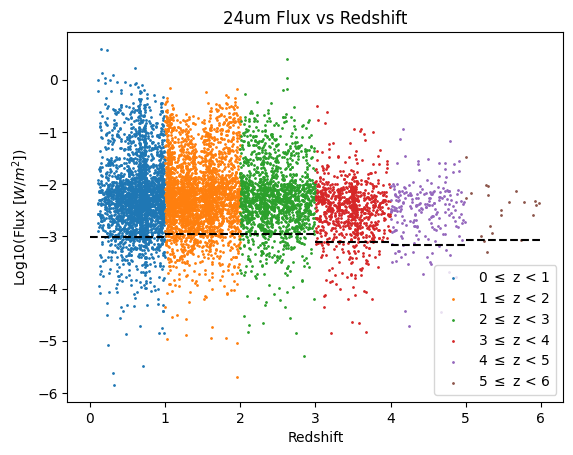

In [23]:
f = df['F24']

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    pc = np.percentile(f[mask_z], 10, method='nearest')
    f_min = f[mask_z][f[mask_z].values == pc]
    plt.scatter(z[mask_z], np.log10(f[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    plt.hlines(np.log10(f_min), linestyle='--', xmin=z_start, xmax=z_end, color='black')
plt.title('24um Flux vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Log10(Flux [$W/m^2$])')
plt.legend()
plt.show()

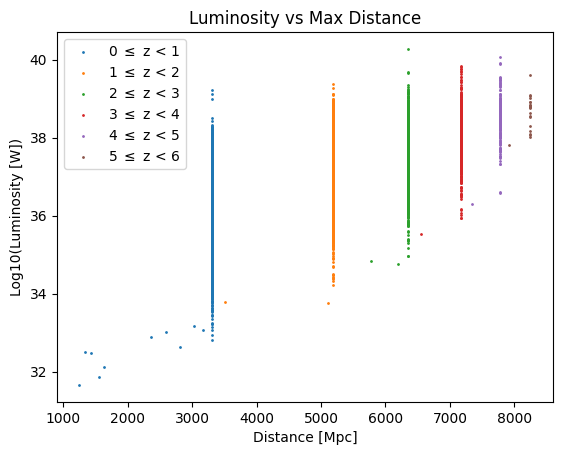

In [24]:
data = []
lum_limits = []

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    
    # Redshift bin distance limits
    dmin = cosmo.comoving_distance(z_start) # Mpc
    dmax = cosmo.comoving_distance(z_end) # Mpc
    
    # Distance to each galaxy
    d = cosmo.comoving_distance(z[mask_z]) # Mpc
    
    # From the minimum detectable flux in the redshift bin, get the minimum luminosity 
    lum_min = lum[mask_z].values[np.argmin(f[mask_z])]
    z_lim = z[mask_z].values[np.argmin(f[mask_z])]
    lum_limits.append([z_lim, lum_min])
    
    # Calculate the maximum distance to each galaxy given the minimum detectable luminosity
    dmaxs = d * np.sqrt(lum[mask_z] / lum_min)
    
    # Set the maximum distance to the maximum redshift bin distance
    dmaxs.values[dmaxs > dmax] = dmax
    
    # Remove galaxies with maximum distance less than minimum distance
    mask_d = dmaxs > dmin
    dmaxs = dmaxs[mask_d]
    lum_bin = lum[mask_z & mask_d]
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    data.append([vol, np.log10(lum_bin)])
    
    plt.scatter(dmaxs, np.log10(lum_bin), s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Max Distance')
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()

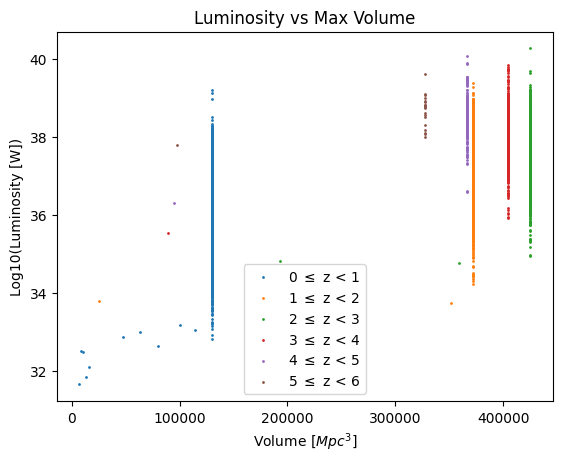

In [25]:
for (z_start, z_end), (v, l) in zip(redshift_bins, data):
    mask = (z >= z_start) & (z < z_end)
    plt.scatter(v, l, s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Max Volume')
plt.xlabel('Volume [$Mpc^3$]')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()

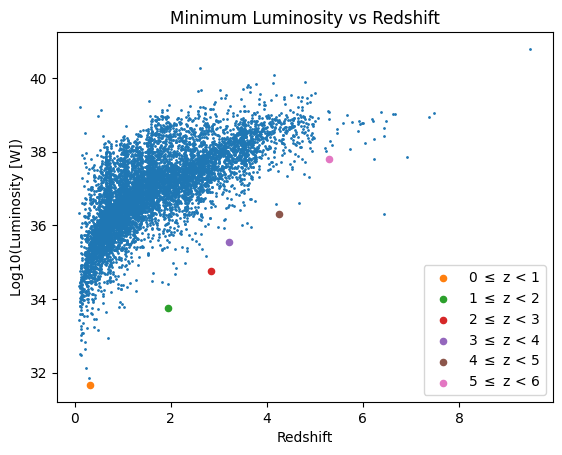

In [26]:
plt.scatter(z, np.log10(lum), s=1)
for (z_start, z_end), (rs, l) in zip(redshift_bins, lum_limits):
    plt.scatter(rs, np.log10(l), s=20, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Minimum Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (v, l), bins, ax in zip(redshift_bins, data, all_mag_bins, axes.flatten()):
    mask = (z >= z_start) & (z < z_end)
    
    # Bin the original data
    _, b, _ = ax.hist(np.log10(lum[mask]), bins=bins, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(l, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    b = b[:-1][c_mask]
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    # ax.axvline(M_abs_lim(z_end), color='darkorchid', linestyle='--', label=f'Magnitudes > {round(M_abs_lim(z_end), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)
    
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

In [ ]:
lum_centers, phi, phi_e = [], [], []

# Volume and magnitude are already binned by redshift
for (vol, lums), bin, in zip(data, bin_edges):
    
    # delta_log_l = np.diff(np.log10(np.abs(bin[::-1])))[0]
    delta_log_l = np.diff(bin)[0]
    print(delta_log_l)
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lums >= lum_start) & (lums < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend()

fig.supxlabel('Log($L_{IR}$)', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(schechter_magnitude(lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(lum, 
        np.log10(schechter_magnitude(lum, *p_down)),
        np.log10(schechter_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error') 
    ax.legend(loc='lower right')

fig.supxlabel('Log($L_{IR}$)', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
def saunders_magnitude(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0 = [lum[0], 0.001, -0.9, 0.1]
    try:
        params, _ = curve_fit(saunders_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(saunders_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(saunders_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        continue        
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(saunders_magnitude(lum, *params)), color='red', label='Saunders Fit', linestyle='--')   
    ax.fill_between(lum, 
        np.log10(saunders_magnitude(lum, *p_down)), 
        np.log10(saunders_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower right')

fig.supxlabel('Log($L_{IR}$)', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()